# Linear regression with ``gluon``

Now that we've implemented a whole neural network from scratch, using nothing but ``mx.ndarray`` and ``mxnet.autograd``, let's see how we can make the same model while doing a lot less work. 

Again, let's import some packages, this time adding ``mxnet.gluon`` to the list of dependencies.

In [1]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd, gluon

## Set the context

We'll also want to set a context to tell gluon where to do most of the computation.

In [2]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

## Build the dataset

Again we'll look at the problem of linear regression and stick with the same synthetic data. 

In [3]:
num_inputs = 2
num_outputs = 1
num_examples = 10000

def real_fn(X):
    return 2 * X[:, 0] - 3.4 * X[:, 1] + 4.2
    
X = nd.random_normal(shape=(num_examples, num_inputs))
noise = 0.01 * nd.random_normal(shape=(num_examples,))
y = real_fn(X) + noise

## Load the data iterator

We'll stick with the ``DataLoader`` for handling out data batching.

In [4]:
batch_size = 4
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X, y),
                                      batch_size=batch_size, shuffle=True)

## Define the model

When we implemented things from scratch, 
we had to individually allocate parameters 
and then compose them together as a model. 
While it's good to know how to do things from scratch, 
with `gluon`, we can just compose a network from predefined layers. 
For a linear model, the appropriate layer is called `Dense`. 
It's called a *dense* layer because every node in the input 
is connected to every node in the subsequent layer. 
That description seems excessive 
because we only have one (non-input) layer here, 
and that layer only contains one node!
But in subsequent chapters we'll typically work 
with networks that have multiple outputs, 
so we might as well start thinking in terms of layers of nodes. 
Because a linear model consists of just a single `Dense` layer, we can instantiate it with one line.

但在后面的章节中，我们将通常处理具有多个输出的网络，因此我们不妨从节点层开始考虑。因为线性模型只包含一个致密层，我们可以用一条线来实例化它。

As in [the previous notebook](linear-regression-scratch.ipynb), 
we have an inputdimension of 2 and an output dimension of 1. 
the most direct way to instantiate a ``Dense`` layer with these dimensions
is to specify the number of inputs and the number of outputs. 

在以前的notebook，我们有2个输入维度和1输出维度。用这些维度来实例化稠密层的最直接的方法是指定输入的数量和输出的数量。

In [5]:
net = gluon.nn.Dense(1, in_units=2)

That's it! We've already got a neural network. 
Like our hand-crafted model in the previous notebook, 
this model has a weight matrix and bias vector.

我们已经有了一个神经网络。就像我们在前面notebook里手工制作的模型一样，这个模型有一个权重矩阵和偏置向量。


In [6]:
print(net.weight)
print(net.bias)

Parameter dense0_weight (shape=(1, 2), dtype=<class 'numpy.float32'>)
Parameter dense0_bias (shape=(1,), dtype=<class 'numpy.float32'>)


Here, `net.weight` and `net.bias` are not actually NDArrays.
They are instances of the `Parameter` class.
We use `Parameter` instead of directly accessing NDAarrays for several reasons. 
For example, they provide convenient abstractions for initializing values.
Unlike NDArrays, Parameters can be associated with multiple contexts simulataneously.
This will come in handy in future chapters when we start thinking about distributed learning across multiple GPUs.

在这里，net.weight和net.bias实际上并不是ndarrays。它们的`Parameter`的实例。我们使用`Parameter`，而不是直接访问ndaarrays有几个原因。例如，它们为初始化值提供了方便的抽象。不像ndarrays，参数可以同时关联到多个contexts。在今后我们开始考虑跨多个GPU的分布式学习的章节里,这将派上用场.

In `gluon`, all neural networks are made out of Blocks (`gluon.Block`).
Blocks are just units that take inputs and generates outputs.
Blocks also contain parameters that we can update. 
Here, our network consists of only one layer, 
so it's convenient to access our parameters directly. 
When our networks consist of 10s of layers, this won't be so fun.
No matter how complex our network, 
we can grab all its parameters by calling `collect_params()` as follows:

在 `gluon`中，所有的神经网络都是由块(`gluon.Block`）组成的。块只是输入和产生输出的单元。块还包含可以更新的参数。这里，我们的网络只有一层，所以直接访问我们的参数是很方便的。当我们的网络是由几十层，就不会那么简单。无论我们的网络多么复杂，我们可以通过调用 `collect_params()` 抓住所有的参数，如下

In [8]:
net.collect_params()

dense0_ (
  Parameter dense0_weight (shape=(1, 2), dtype=<class 'numpy.float32'>)
  Parameter dense0_bias (shape=(1,), dtype=<class 'numpy.float32'>)
)

The returned object is a `gluon.parameter.ParameterDict`. 
This is a convenient abstaction for retrieving and manipulating groups of Parameter objects.
Most often, we'll want to retrieve all of the parameters in a neural network 

返回的对象是一个 `gluon.parameter.ParameterDict`。用于检索和操作参数对象群，这是一个方便的抽象。大多数情况下，我们希望获得神经网络中的所有参数。

In [9]:
type(net.collect_params())

mxnet.gluon.parameter.ParameterDict

## Initialize parameters
Once we initialize our Parameters, we can access their underlying data and context(s),
and we can also feed data through the neural network to generate output.
However, we can't get going just yet. 
If we try invoking your model by calling ``net(nd.array([[0,1]]))``, 
we'll confront the following hideous error message:

一旦初始化参数，我们就可以访问它们的底层数据和上下文，我们也可以通过神经网络来输入数据以产生输出。然而，我们现在还不能去做。
如果我们尝试调用你的模型通过调用``net(nd.array([[0,1]]))``, 
我们将面对以下可怕的错误消息：

``RuntimeError: Parameter dense1_weight has not been initialized. 
Note that you should initialize parameters and create Trainer 
with Block.collect_params() instead of Block.params because the later does not include Parameters of nested child Blocks``.

That's because we haven't yet told ``gluon`` what the *initial values* for our parameters should be!
We initialize parameters by calling the `.initialize()` method of a Parameterdict. 
We'll need to pass in two arguments. 

这是因为我们还没有告诉 ``gluon`` 我们的参数的*初始值*应该是多少！我们通过调用一个Parameterdict `.initialize()` 方法来初始化参数。我们需要传递两个参数。

* An initializer, many of which live in the `mx.init` module. 
* A context where the parameters should live. In this case we'll pass in the `model_ctx`. Most often this will either be a GPU or a list of GPUs. 



* 初始值设定项，其中许多都存在于`mx.init`模块中。
* 包含参数上下文。在这种情况下，我们会传入` model_ctx `。这通常是一个或一系列GPU。
 
 
*MXNet* provides a variety of common initializers in ``mxnet.init``.
To keep things consistent with the model we built by hand, 
we'll initialize each parameter by sampling from a standard normal distribution, 
using `mx.init.Normal(sigma=1.)`.

*MXNet*  在``mxnet.init``包里提供各种常见初始化器 
为了使事情与我们手工构建的模型保持一致，我们将使用标准的正态分布抽样，对每个参数进行初始化，使用 `mx.init.Normal(sigma=1.)`.

In [11]:
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=model_ctx)

## Deferred Initialization

When we call ``initialize``, ``gluon`` associates each parameter with an initializer.
However, the *actual initialization* is deferred until we make a first forward pass. 
In other words, the parameters are only initialized when they're needed. 
If we try to call `net.weight.data()` we'll get the following error:

## 延迟初始化
当我们调用 ``initialize``, ``gluon`` 将每个参数与初始化器相关联。但是，*实际初始化*被推迟到我们取得第一个前向传递的时候。换句话说，参数只有在需要时才初始化。如果我们试着调用 `net.weight.data()`  我们会得到下面的错误：

``DeferredInitializationError: Parameter dense2_weight has not been initialized yet because initialization was deferred. Actual initialization happens during the first forward pass. Please pass one batch of data through the network before accessing Parameters.``

Passing data through a `gluon` model is easy. 
We just sample a batch of the appropriate shape and call `net` 
just as if it were a function. 
This will invoke net's `forward()` method.

通过`gluon`模型传递数据是很容易的。我们只是对一组合适的形状进行采样，并调用`net` 好像它是一个函数一样。这将调用net的forward()方法。

In [12]:
example_data = nd.array([[4,7]])
net(example_data)


[[ 8.98771858]]
<NDArray 1x1 @cpu(0)>

Now that `net` is initialized, we can access each of its parameters. 

In [13]:
print(net.weight.data())
print(net.bias.data())


[[ 0.85240513  0.79687119]]
<NDArray 1x2 @cpu(0)>

[ 0.]
<NDArray 1 @cpu(0)>


## Shape inference

Recall that previously, we instantiated our network with `gluon.nn.Dense(1, in_units=2)`. 
One slick feature that we can take advantage of in ``gluon`` is shape inference on parameters. 
Because our parameters never come into action until we pass data through the network,
we don't actually have to declare the input dimension (`in_units`). 
Let's try this again, but letting `gluon` do more of the work:

# 形状推断

回想以前，我们通过 `gluon.nn.Dense(1, in_units=2)` 实例化我们的网络。我们可以利用``gluon``的一个聪明的特性，那就是参数的形状推断。因为我们传递数据到网络之前我们的参数从来不会被初始化，我们实际上不必申明输入维度（in_units）。让我们再试一次，但会让`gluon` 做更多的工作：

In [14]:
net = gluon.nn.Dense(1)
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=model_ctx)

We'll elaborate on this and more of ``gluon``'s internal workings in subsequent chapters.

我们将在后面的章节中详细阐述这个和更多的``gluon``的内部运作。

## Define loss

Instead of writing our own loss function we're just going to access squared error by instantiating ``gluon.loss.L2Loss``. Just like layers, and whole networks, a loss in gluon is just a `Block`.

## 定义损失

我们将仅仅通过实例化 ``gluon.loss.L2Loss`` 来获取均方误差，而不是写我们自己的损失函数 。就像层和整个网络一样，损失在gluon中只是一个“块”。


In [15]:
square_loss = gluon.loss.L2Loss()

## Optimizer

Instead of writing stochastic gradient descent from scratch every time, we can instantiate a ``gluon.Trainer``, passing it a dictionary of parameters. Note that the ``sgd`` optimizer in ``gluon`` actually uses SGD with momentum and clipping (both can be switched off if needed), since these modifications make it converge rather much better. We will discuss this later when we go over a range of optimization algorithms in detail.

## 优化器

我们不必每次都从头开始写随机梯度下降，我们可以实例化一个``gluon.Trainer``，将一个字典型参数传给它。注意在``gluon``中， ``sgd``优化器实际使用SGD动量和裁剪（都可以关闭，如果需要的话），因为这些修改使其更好收敛。稍后我们将详细讨论一系列优化算法。

In [16]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

## Execute training loop

You might have noticed that it was a bit more concise to express our model in ``gluon``. For example, we didn't have to individually allocate parameters, define our loss function, or implement stochastic gradient descent. The benefits of relying on ``gluon``'s abstractions will grow substantially once we start working with much more complex models. But once we have all the basic pieces in place, the training loop itself is quite similar to what we would do if implementing everything from scratch. 

你可能已经注意到，用``gluon``表达我们的模型是比较简洁的。例如，我们不需要单独分配参数，定义损失函数，或者实现随机梯度下降。一旦我们开始使用更复杂的模型，依赖``gluon`` 的抽象的好处将大大增加。但是一旦我们有了所有基本的部分，训练循环本身就非常类似于我们从头开始实现一切。


## 训练

To refresh your memory. For some number of ``epochs``, we'll make a complete pass over the dataset (``train_data``), grabbing one mini-batch of inputs and the corresponding ground-truth labels at a time. 

刷新一下你的记忆。对于一些` `epochs` `，我们会做一个完整的传过来的数据集（` ` train_data ` `），每次抓取输入里的一个小batch和相应的真实标签。

Then, for each batch, we'll go through the following ritual. So that this process becomes maximally ritualistic, we'll repeat it verbatim:
然后，每一个batch，我们将通过一下惯例。让这个过程变得最大限度的惯例，我们将逐字地重复：

* Generate predictions (``yhat``) and the loss (``loss``) by executing a forward pass through the network.
* Calculate gradients by making a backwards pass through the network via ``loss.backward()``. 
* Update the model parameters by invoking our SGD optimizer (note that we need not tell ``trainer.step`` about which parameters but rather just the amount of data, since we already performed that in the initialization of ``trainer``).


* 通过网络执行一个forward pass 前向传递 生成预测 (``yhat``) 和损失(``loss``) 
* 利用``loss.backward()`` 通过网络生成一个反向传递来计算梯度。
* 通过调用我们的SGD优化器来更新模型参数（注意，我们不需要告诉``trainer.step``哪些参数，而只是数据量，因为我们在``trainer``初始化中已经完成这些）。

In [17]:
epochs = 10
learning_rate = .0001
loss_sequence = []

for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += nd.mean(loss).asscalar()
    print("Epoch %s, loss: %s" % (e, cumulative_loss / num_examples))
    loss_sequence.append(cumulative_loss)


Epoch 0, loss: 0.0107051503119
Epoch 1, loss: 1.30396030197e-05
Epoch 2, loss: 1.30381947897e-05
Epoch 3, loss: 1.3109341069e-05
Epoch 4, loss: 1.31099881296e-05
Epoch 5, loss: 1.30834395102e-05
Epoch 6, loss: 1.30859975455e-05
Epoch 7, loss: 1.30581023294e-05
Epoch 8, loss: 1.30572632249e-05
Epoch 9, loss: 1.30876914578e-05


## Visualizing the learning curve
Now let's check how quickly SGD learns the linear regression model by plotting the learning curve.


## 可视化学习曲线
现在让我们通过绘制学习曲线，来看看SGD如何快速地学习线性回归模型的


Text(0,0.5,'average loss')

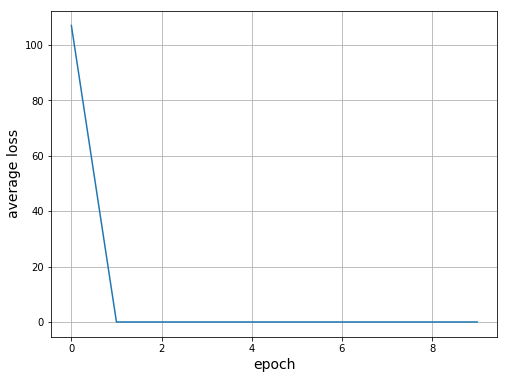

In [18]:
# plot the convergence of the estimated loss function 
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None,figsize=(8, 6))
plt.plot(loss_sequence)

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('average loss',fontsize=14)

As we can see, the loss function converges quickly to the optimal solution.

可以看出，损失函数收敛到最优解。

## Getting the learned model parameters

As an additional sanity check, since we generated the data from a Gaussian linear regression model, we want to make sure that the learner managed to recover the model parameters, which were set to weight $2,-3.4$ with an offset of $4.2$.


## 获取学习模型参数
作为一个额外的健全检查，由于我们从高斯线性回归模型中生成数据，我们希望确保学习者设法找到模型参数，这些参数被设置为2，3.4，偏移量为4.2。
    

In [19]:
params = net.collect_params() # this returns a ParameterDict

print('The type of "params" is a ',type(params))

# A ParameterDict is a dictionary of Parameter class objects
# therefore, here is how we can read off the parameters from it.

for param in params.values():
    print(param.name,param.data())

The type of "params" is a  <class 'mxnet.gluon.parameter.ParameterDict'>
dense1_weight 
[[ 1.99950063 -3.40032887]]
<NDArray 1x2 @cpu(0)>
dense1_bias 
[ 4.1995225]
<NDArray 1 @cpu(0)>


## Conclusion 

As you can see, even for a simple example like linear regression, ``gluon`` can help you to write quick, clean, code. Next, we'll repeat this exercise for multi-layer perceptrons, extending these lessons to deep neural networks and (comparatively) real datasets. 

## 结论

正如你所看到的，即使是像线性回归这样的简单例子，“``gluon`` 也能帮助你写出快速、干净的代码。接下来，我们将对多层感知器重复这个练习，将这些教程扩展到深度神经网络和真实数据集（相对的）。

## Next
[The perceptron algorithm](../chapter02_supervised-learning/perceptron.ipynb)

For whinges or inquiries, [open an issue on  GitHub.](https://github.com/zackchase/mxnet-the-straight-dope)